<a href="https://colab.research.google.com/github/cooperhammond/nn-interpretability/blob/master/Visualizing_Polytopes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed

In [90]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

iris = datasets.load_iris()
X = iris.data#[:, 2:4]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [91]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from sklearn.preprocessing import normalize

def gen_model(bias_initializer = 'random_uniform'):
    model = Sequential()
    model.add(InputLayer(input_shape=(4,)))
    model.add(Dense(40, activation='relu', bias_initializer=bias_initializer))
    model.add(Dense(20, activation='relu', bias_initializer=bias_initializer))
    model.add(Dense(3, activation='softmax', bias_initializer=bias_initializer))

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

In [92]:
from sympy import Eq, Matrix, symbols, solveset
import random

def gen_layer_polytopes(model, layer_idx, prev_activations, free_dim, fd_placement="start"):
    """
    :param int|list free_dim: if int, that many free_dimensions; if list, use the elements as the free 
                              dimensions
    :param str|list fd_placement: if str: "start" would replace the first n prev_activations with the 
                                        generated free dimensions, "end" would replace the end, and random
                                        place them randomly
    """
    prev_activations = list(prev_activations)
    activations = []
    layer = model.layers[layer_idx]
    layer_weights = layer.get_weights()
    
    if type(free_dim) is int:
        free_dim = list(symbols('x:' + str(free_dim)))
        n_fd = len(free_dim)
        if fd_placement is "start":
            fd_placement = list(range(0, n_fd))
        elif fd_placement is "end":
            fd_placement = list(range(len(prev_activations) - n_fd, len(prev_activations)))
        elif fd_placement is "random":
            fd_placement = random.sample(range(0, len(prev_activations)), n_fd)

    for i, dim in enumerate(free_dim):
        prev_activations[fd_placement[i]] = dim
         
    for neuron_idx in range(0, layer_weights[0].shape[-1]):
        current_weights = [weights[neuron_idx] for weights in layer_weights[0]]
        b = layer_weights[1][neuron_idx]
        
        #print(current_weights, prev_activations, b)
        eq = (Matrix([current_weights]) * Matrix(prev_activations) + Matrix([b]))[0]
        
        activations.append(eq)

    return activations

#m = gen_model()
#gen_layer_polytopes(m, 1, prev_activations=[2.0, 1.4, 0.2, 0.4, 0.3, 0.5, 0.7, 7.8], free_dim=2, 
#                    fd_placement="start", solve=True)

In [93]:
def generate_polytope_bounds(model, layer_idx, features, free_dim=2, solve=True, return_all=False, flatten=True): 
    total_activations = [[]]
    prev_activations = gen_layer_polytopes(model, 0, features, free_dim, fd_placement="start")
    solve_for = symbols("x0")
    
    for i in range(1, layer_idx + 1):        
        if solve:
            total_activations += [[solveset(eq, solve_for).args[0] for eq in prev_activations]]
        else:
            total_activations += [prev_activations]
        prev_activations = gen_layer_polytopes(model, i, prev_activations, 0)
    
    if return_all:
        if flatten:
            total_activations = [element for sublist in total_activations for element in sublist]
        return total_activations
    else:
        return total_activations[layer_idx]

In [95]:
%%time
m = gen_model()
generate_polytope_bounds(m, len(m.layers)-1, X[40], free_dim=2, return_all=True, flatten=True, solve=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 40)                200       
                                                                 
 dense_19 (Dense)            (None, 20)                820       
                                                                 
 dense_20 (Dense)            (None, 3)                 63        
                                                                 
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2.52 s, sys: 9.14 ms, total: 2.53 s
Wall time: 2.52 s


[1.54803095376383 - 0.0199179*x1,
 1.78366*x1 + 1.57196295353781,
 12.5464418273618 - 14.415*x1,
 -0.288627*x1 - 1.72520255597018,
 1.52466118028034 - 0.00960548*x1,
 3.45841*x1 - 2.49048733107978,
 1.29525*x1 + 0.955734113938365,
 1.23687*x1 + 0.100525518874537,
 -4.21283*x1 - 0.930080997292869,
 0.170142*x1 + 1.65939608399604,
 1.32051903924286 - 0.649912*x1,
 -0.398779*x1 - 2.58813748975812,
 -2.83425*x1 - 4.42786962054289,
 0.671402194682863 - 1.03275*x1,
 0.641446200030723 - 0.995636*x1,
 1.74093533830017 - 0.271631*x1,
 1.74819691991431 - 1.96865*x1,
 1.14007*x1 + 0.310442144887899,
 0.831766937136717 - 3.36046*x1,
 0.140986*x1 + 1.15154184596354,
 -0.164179*x1 - 0.91943567239534,
 -1.51526*x1 - 0.970357357952315,
 8.10353234228893 - 3.43497*x1,
 0.418496*x1 - 0.830626103422375,
 -1.0754*x1 - 0.180322046973663,
 0.018165079890792 - 0.0634574*x1,
 -1.57469*x1 - 3.22547482545413,
 1.05704*x1 - 0.338500492112883,
 -4.0241*x1 - 1.88295837409011,
 0.438293700769393 - 1.58144*x1,
 -0.2

In [104]:
def graph_polytope_boundaries(polytope_bounds, epoch=0):
    from sympy.core.mul import Mul
    import matplotlib

    fig = plt.figure(epoch)
    fig.clf()
    ax = fig.add_subplot()

    l = 1.2
    ax.set_xlim([-l, l])
    ax.set_ylim([-l, l])
    
    for line in polytope_bounds:                
            intercept = 0
            slope = 0
            if type(line.args[1]) == Mul:
                intercept = line.args[0]
                slope = line.args[1].args[0]
            else:
                slope = line.args[0] 
        
            x = np.linspace(-l, l, int(l * 15))
            ax.plot(x, slope * x + intercept, '-', color="black", linewidth=0.5)

            plt.savefig(f'./img/img_{epoch}.png', 
                transparent = False,  
                facecolor = 'white'
               )

In [105]:
class PolytopeVisualizationCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % 1 == 0:
            polytope_bounds = generate_polytope_bounds(self.model, 1, X[40], free_dim=2, return_all=True)
            graph_polytope_boundaries(polytope_bounds, epoch=epoch)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 40)                200       
                                                                 
 dense_28 (Dense)            (None, 20)                820       
                                                                 
 dense_29 (Dense)            (None, 3)                 63        
                                                                 
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 1s 3ms/step - loss: 1.6467 - accuracy: 0.0000e+00
Epoch 2/30
4/4 [==============================] - 0s 2ms/step - loss: 1.4456 - accuracy: 0.0000e+00
Epoch 3/30
4/4 [==============================] - 0s 2ms/step - loss: 1.2654 - accuracy: 0.0370
Epoch 4/30
4/4 [====

/home/cooper/.anaconda3/envs/lucid-venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


Epoch 21/30
4/4 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.7185
Epoch 22/30
4/4 [==============================] - 0s 2ms/step - loss: 0.6764 - accuracy: 0.7704
Epoch 23/30
4/4 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.7926
Epoch 24/30
4/4 [==============================] - 0s 2ms/step - loss: 0.6394 - accuracy: 0.8222
Epoch 25/30
4/4 [==============================] - 0s 2ms/step - loss: 0.6219 - accuracy: 0.8148
Epoch 26/30
4/4 [==============================] - 0s 2ms/step - loss: 0.6060 - accuracy: 0.8000
Epoch 27/30
4/4 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.8000
Epoch 28/30
4/4 [==============================] - 0s 2ms/step - loss: 0.5740 - accuracy: 0.8222
Epoch 29/30
4/4 [==============================] - 0s 2ms/step - loss: 0.5619 - accuracy: 0.9037
Epoch 30/30
4/4 [==============================] - 0s 2ms/step - loss: 0.5465 - accuracy: 0.9185


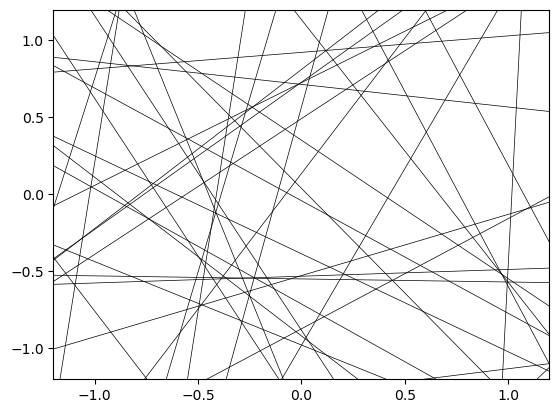

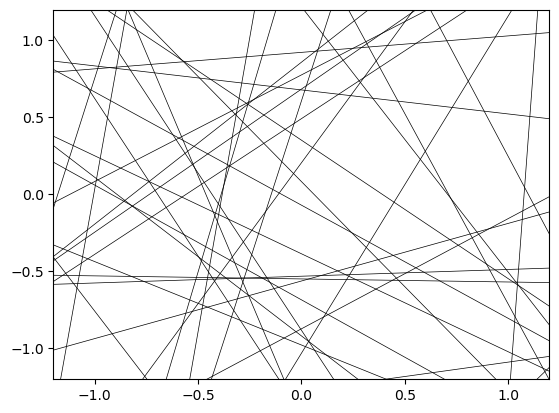

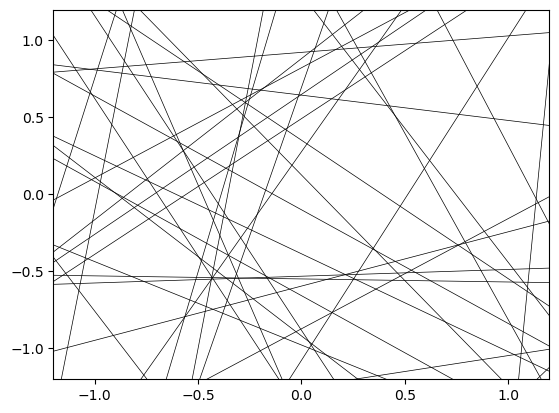

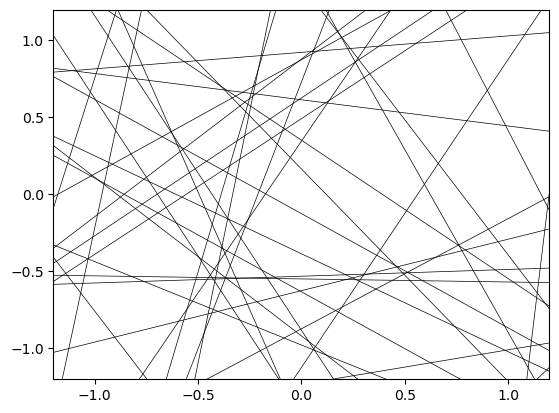

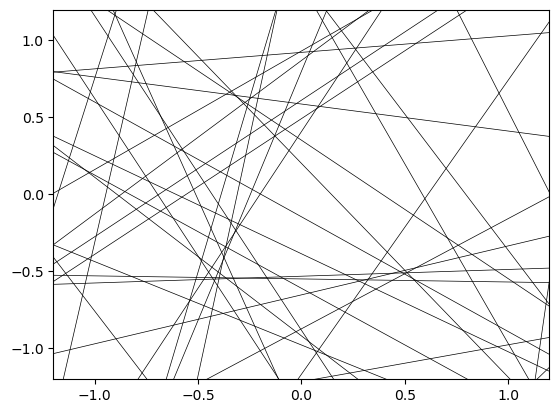

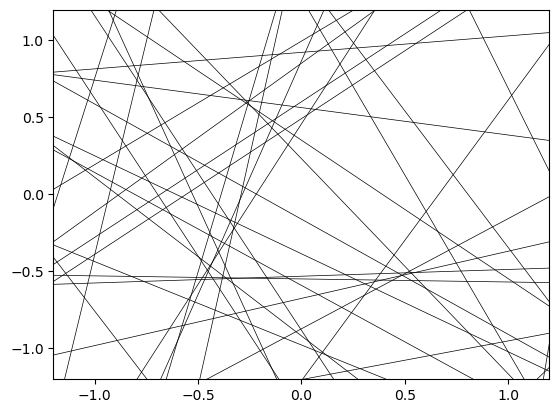

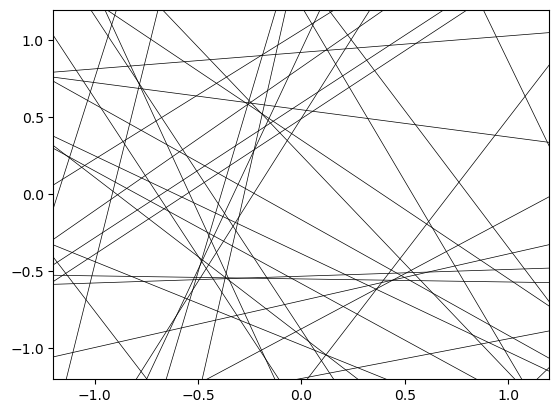

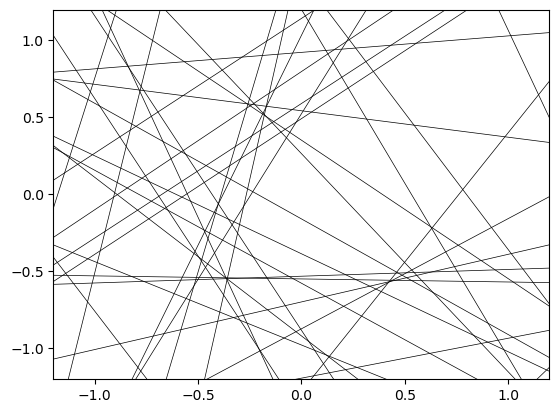

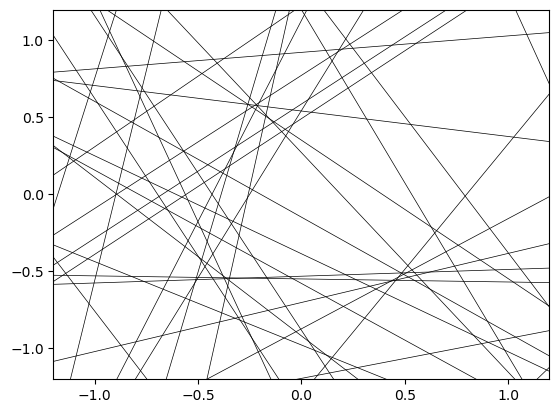

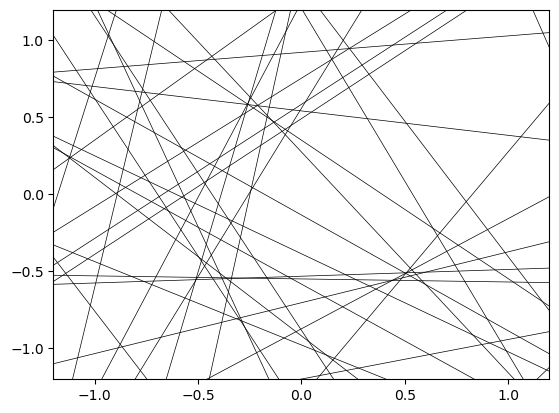

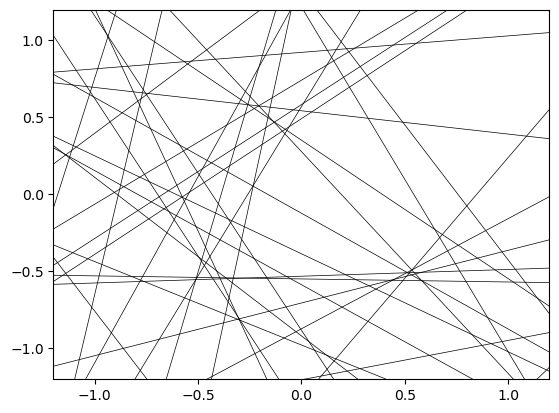

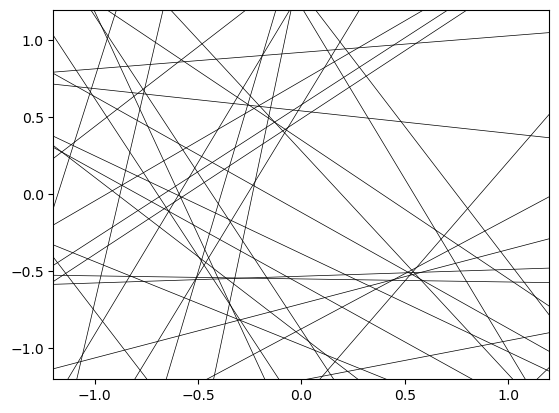

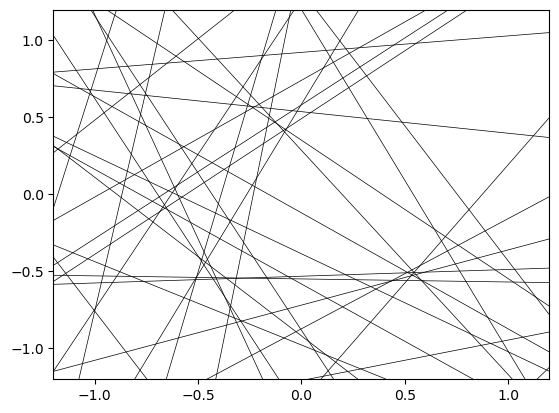

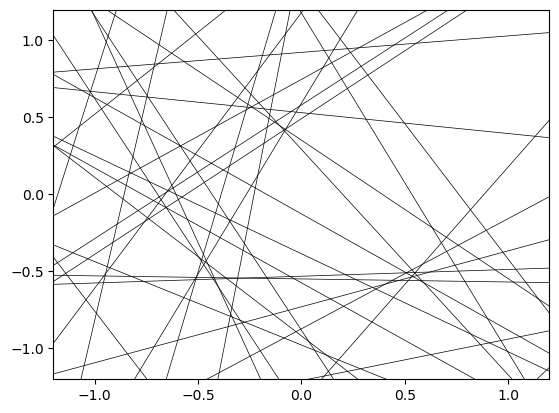

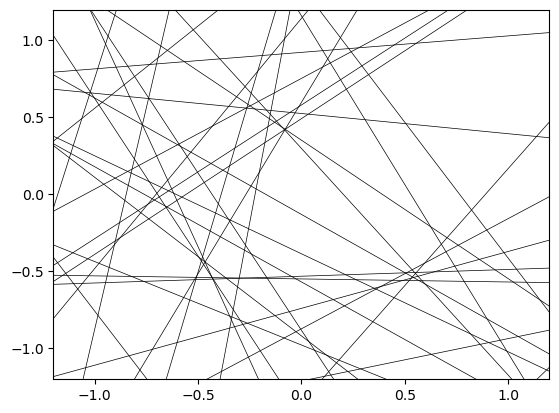

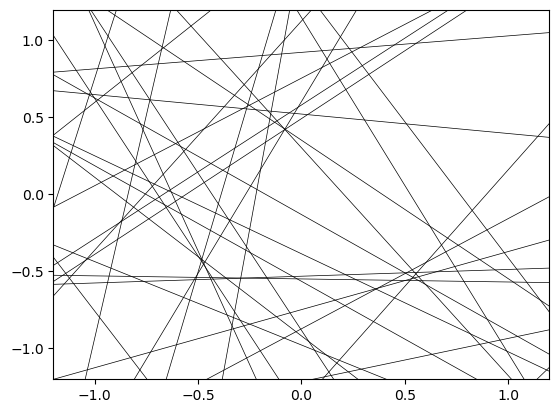

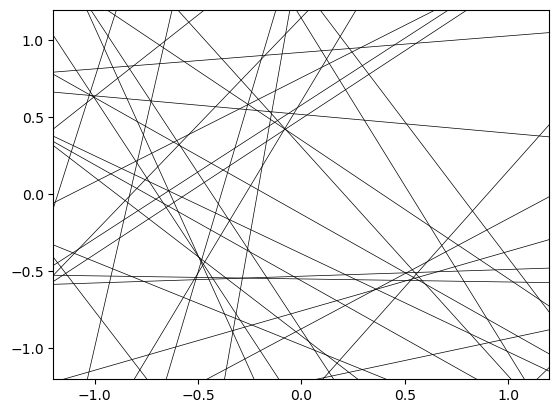

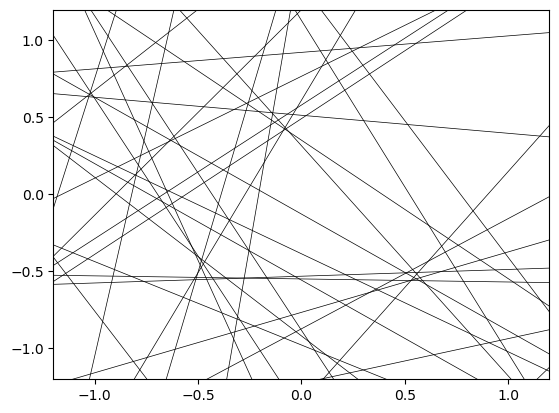

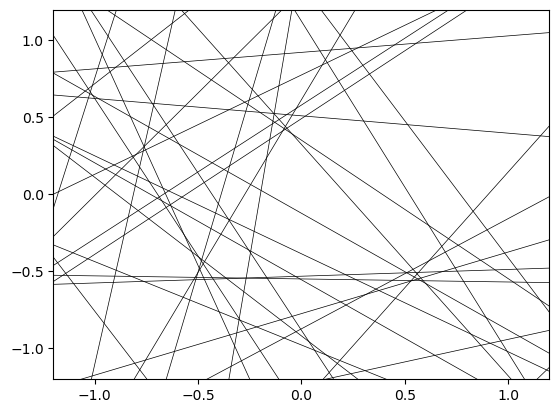

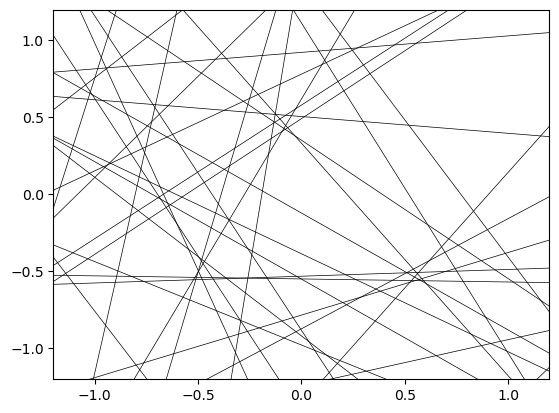

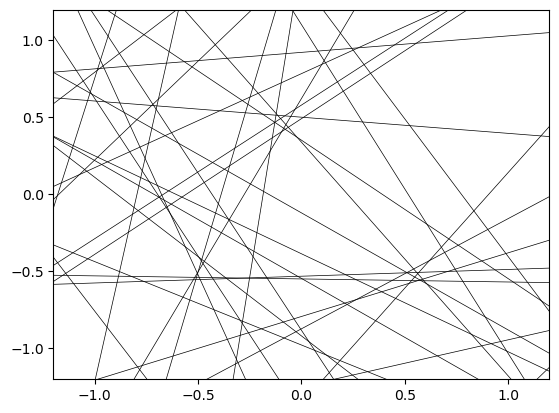

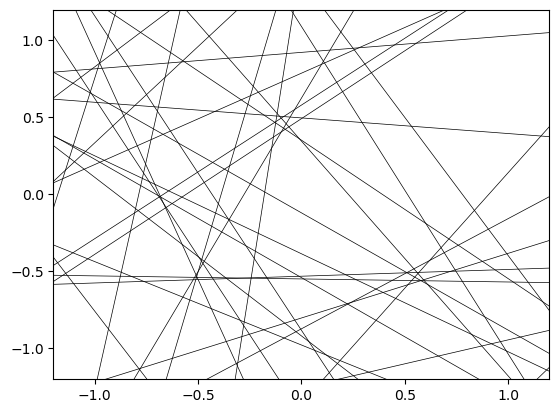

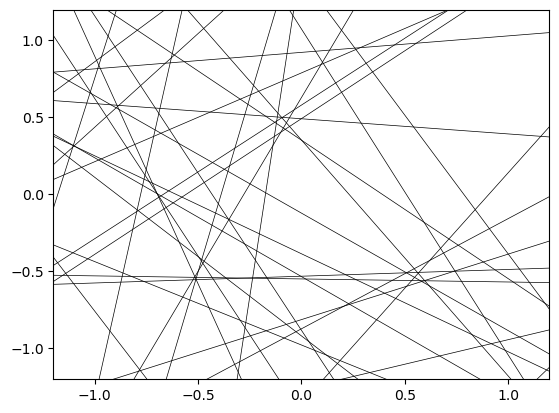

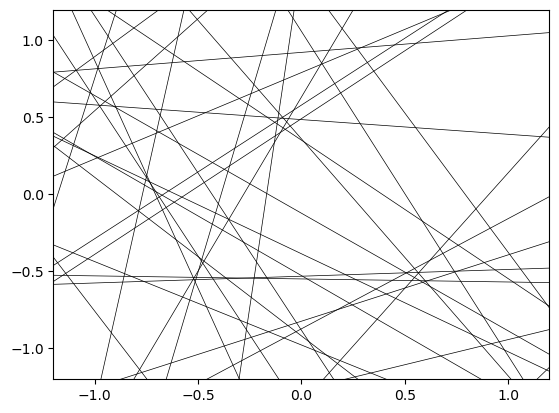

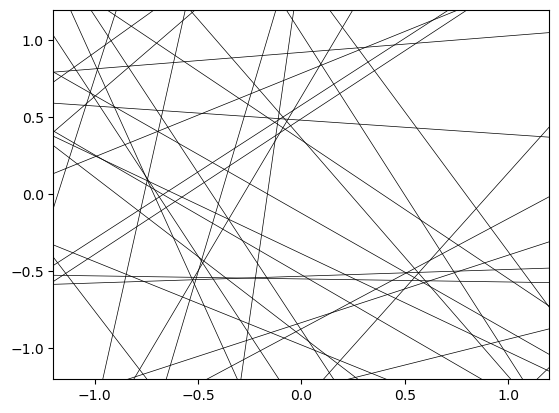

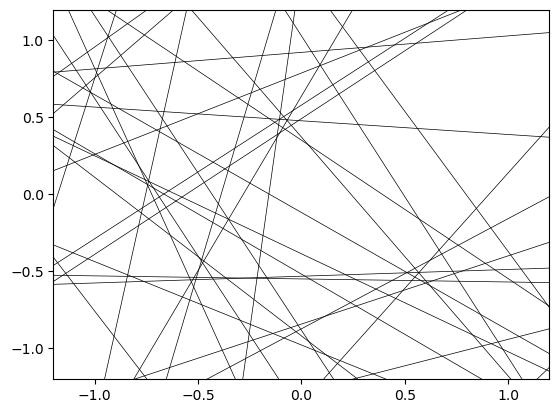

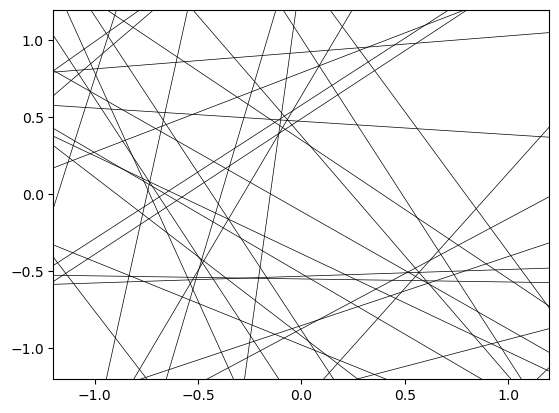

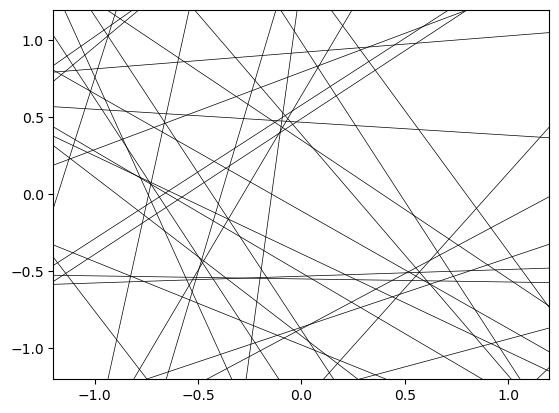

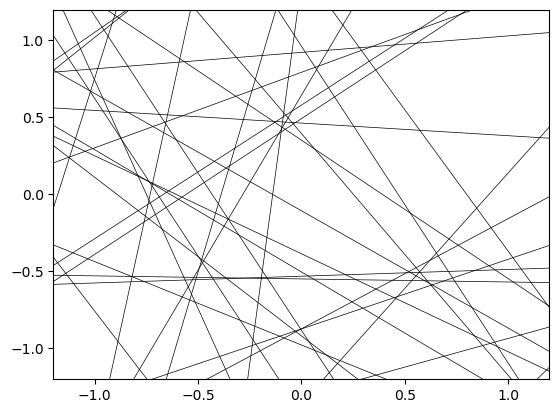

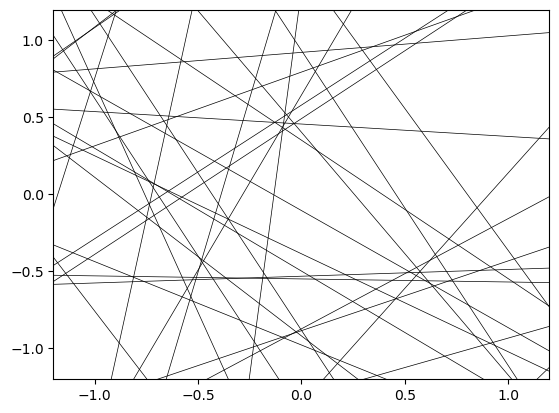

In [106]:
!rm ./img -r
!mkdir ./img

model = gen_model()
epochs = 30
model.fit(
    X_train, 
    train_labels, 
    epochs=epochs, 
    batch_size=40, 
    callbacks=[PolytopeVisualizationCallback()]
)

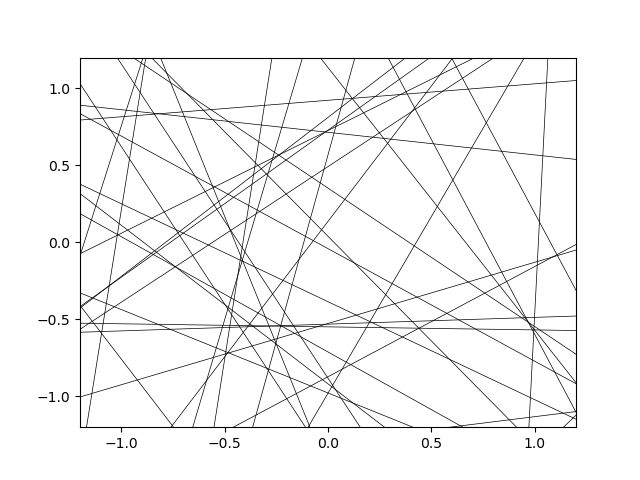

In [107]:
import imageio
import os

frames = [] 

for epoch in range(0, epochs):
    image = imageio.v2.imread(f'./img/img_{epoch}.png')
    frames.append(image)

gif_path = "./out.gif"
imageio.mimsave(gif_path, frames, fps = 2)

from IPython.display import Image
display(Image(data=open(gif_path,'rb').read(), format='png'))

$$
a^i_j = max(\begin{bmatrix} w^{i-1}_{1,j} & . . . & w^{i-1}_{len(a^{i-1}),j}\end{bmatrix}
            \begin{bmatrix} a^{i-1}_1\\ ... \\ a^{i-1}_{len(a^{i-1})}\end{bmatrix} + b^i_j, 0)
$$

In [ ]:
x_bounds = X[:, 0]
x_bounds = [x_bounds.min(), x_bounds.max()]
y_bounds = X[:, 1]
y_bounds = [y_bounds.min(), y_bounds.max()]
x_bounds, y_bounds

([1.0, 6.9], [0.1, 2.5])

iris sepals

free dimensions could be outputs just as much as outputs

Two problems:

1) cutting a slice through high dimensional space

2) handling convolutional layers -- how do those translate to polytopes?

Where to take this next:

- [ ] a "suite" of polytope interpretation tools, consisting of:
* given multiple class examples, calculate the Euclidean distance between their spline codes, drawn from their the class example's activation vector
  * would require an ability to map from the activation vector to the spline code: "To calculate the polytope boundary density between two points, we simply divide the Hamming distance in between their spline codes by the Euclidean distance between them. The polytope densities are normalized by dividing by the average polytope density between all pairs of vectors (both intra and inter class)."
* as